In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import time
import datetime
from pyhdf.SD import SD, SDC
from pyhdf import HDF, VS, V
import os
from matplotlib.colors import Normalize, PowerNorm
from matplotlib.cm import get_cmap



In [2]:
#For a single csat file, make a funcition that takes in a file and returns stats of the cloud layers

def csat_stats(path):
    def oneddata(path,searchdatasetlist):
        if type(path)==str:
            h=HDF.HDF(path)
        else:
            h=path
        datasetlist=[]
        for i in searchdatasetlist:
            vs=h.vstart()
            xid=vs.find(i)
            dataid=vs.attach(xid)
            dataid.setfields(i)
            nrecs,_,_,_,_=dataid.inquire()
            data=dataid.read(nRec=nrecs)
            data=list(np.concatenate(data))
            datasetlist.append(data)
            dataid.detach()
            vs.end()
        return datasetlist

    lat, lon, landseaflag = oneddata(path,['Latitude','Longitude', 'Navigation_land_sea_flag'])
    csatfile = SD(path, SDC.READ)
    toparray = np.array(csatfile.select('CloudLayerTop'))
    toparray[toparray==-99.0] = np.nan
    bottomarray = np.array(csatfile.select('CloudLayerBase'))
    bottomarray[bottomarray==-99.0] = np.nan
    typearray = np.array(csatfile.select('CloudLayerType'),dtype=np.float64)
    typearray[typearray==-9.0] = np.nan


    indices = np.where(~np.isnan(typearray)) #Returns a tuple of arrays, one for each dimension of a, containing the indices of the non-nan elements.
    typearray = typearray[indices] #Extracting the type of cloud for each non-nan value (i.e. a cloud or clear case)
    lat = np.take(lat,(indices[0])) #To access elements of list using a 1D array. 
    lon = np.take(lon,(indices[0]))
    landseaflag = np.take(landseaflag,(indices[0]))
    toparray = toparray[indices]
    bottomarray = bottomarray[indices]
    df = pd.DataFrame(columns=['type','lat','lon','top','bottom','landseaflag'])

    df['type'] = typearray
    df['lat'] = lat
    df['lon'] = lon
    df['top'] = toparray
    df['bottom'] = bottomarray
    df['landseaflag'] = landseaflag
    df['thickness'] = df['top'] - df['bottom']
    
    return df

In [18]:
rootdir='/data/debasish/cloudsatdata/cldclasslidar/2019jan'
dflist=[]
for subfolder in os.listdir(rootdir):
    if subfolder.endswith('.csv'): #This is to skip the csv file that is created in the same folder
        continue
    filecount=0
    subfolder_path = os.path.join(rootdir,subfolder)
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path,file)
            df = csat_stats(file_path)
            dflist.append(df)
            filecount=filecount+1
            #Print the length of each df without a new line
            print(len(df),end=' \r')
    print("Folder ",subfolder," done, files processed: ",filecount)
df = pd.concat(dflist, ignore_index=True)
df=df[df['type']!=0]
df['cloudname'] = df['type'].map({1:'Cirrus',2:'Altostratus',3:'Altocumulus',4:'Stratus',5:'Stratocumulus',6:'Cumulus',7:'Nimbostratus'
                ,8:'Deep convective',9:'Unknown'})
df['cloudname'] = df['cloudname'].astype('category')


Folder  day01  done, files processed:  15
Folder  day25  done, files processed:  14
Folder  day12  done, files processed:  13
Folder  day20  done, files processed:  14
Folder  day18  done, files processed:  13
Folder  day24  done, files processed:  15
Folder  day28  done, files processed:  14
Folder  day10  done, files processed:  15
Folder  day15  done, files processed:  14
Folder  day22  done, files processed:  14
Folder  day04  done, files processed:  14
Folder  day26  done, files processed:  15
Folder  day27  done, files processed:  14
Folder  day05  done, files processed:  14
Folder  day11  done, files processed:  15
Folder  day31  done, files processed:  15
Folder  day21  done, files processed:  15
Folder  day30  done, files processed:  14
Folder  day16  done, files processed:  15
Folder  day09  done, files processed:  13
Folder  day13  done, files processed:  14
Folder  day23  done, files processed:  14
Folder  day02  done, files processed:  14
Folder  day03  done, files process

<AxesSubplot:title={'center':'Mean thickness of clouds'}, xlabel='cloudname'>

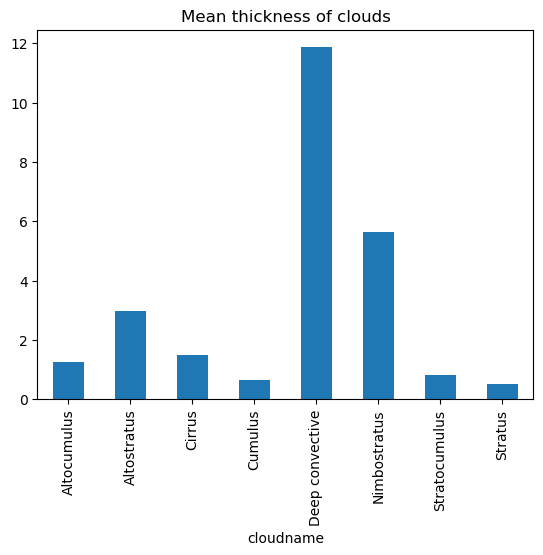

In [27]:
#Add a column to the dataframe to indicate the name of cloud type

df['cloudname'] = df['type'].map({1:'Cirrus',2:'Altostratus',3:'Altocumulus',4:'Stratus',5:'Stratocumulus',6:'Cumulus',7:'Nimbostratus'
                ,8:'Deep convective',9:'Unknown'})
df['cloudname'] = df['cloudname'].astype('category')

df.tail()

df.groupby('cloudname')['thickness'].mean().plot(kind='bar',title='Mean thickness of clouds', y='Mean thickness( in km)',x='cloudname')


In [31]:
#Save the dataframe to a csv file in the folder cloudstats
name = '2019jan.csv'
folder = r'/data/debasish/cloudsatdata/cldclasslidar/2019jan'

df.to_csv(os.path.join(folder,name))

In [33]:
#Check the size of the csv file in MB
os.path.getsize(os.path.join(folder,name))/1e6

751.448607

In [19]:
len(df)

8138239

In [10]:
df['lat'].mean(), df['lon'].mean()

(-2.811640614612036, -0.045647373713710096)

In [11]:
df['type'].value_counts()

5.0    2298176
1.0    1932816
2.0    1394675
6.0     894995
3.0     853769
7.0     572635
4.0     148143
8.0      43030
Name: type, dtype: int64

In [12]:
df.groupby('type')['thickness'].mean()

type
1.0     1.496865
2.0     2.962899
3.0     1.266121
4.0     0.518148
5.0     0.814201
6.0     0.656177
7.0     5.623061
8.0    11.858008
Name: thickness, dtype: float32

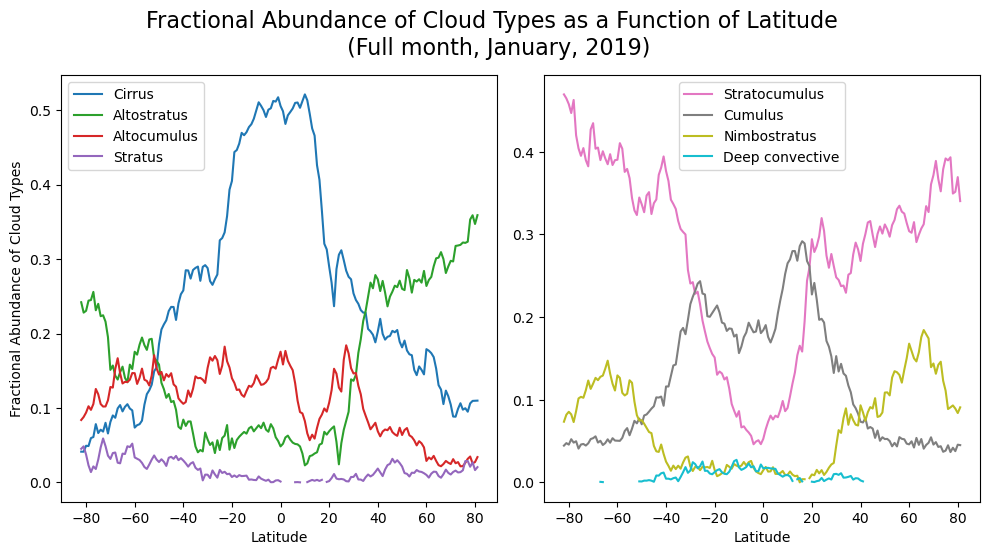

In [16]:
cloudtype_dict={1:'Cirrus',2:'Altostratus',3:'Altocumulus',4:'Stratus',5:'Stratocumulus',6:'Cumulus',7:'Nimbostratus'
                ,8:'Deep convective',9:'Unknown'}
cloudlabel=np.arange(1,10)

fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.figtext(0.5,1.051,'Fractional Abundance of Cloud Types as a Function of Latitude \n (Full month, January, 2019)',ha='center', va='center',fontsize=16)
#Plot the fractional abundance of each cloud type in the dataset
dfcopy = df.copy()
dfcopy['latbin']=np.floor(dfcopy['lat'])
dfcopy['latbin'].value_counts().sort_index()

from matplotlib.colors import Normalize, PowerNorm
from matplotlib.cm import get_cmap

norm = PowerNorm(gamma=0.7) #Sharper colors with better contrast
cmap = get_cmap("tab10")
colors = cmap(norm(np.linspace(0, 1, 10)))

colors_subplot_1 = colors[0:4]
colors_subplot_2 = colors[5:9]

for i, c in enumerate(colors_subplot_1):
    ax[0].plot(dfcopy[dfcopy['type']==i+1].groupby('latbin')['type'].count()/dfcopy.groupby('latbin')['type'].count(),label=cloudtype_dict[i+1], color=c)
    ax[0].set_xlabel('Latitude')
    ax[0].set_ylabel('Fractional Abundance of Cloud Types')
    ax[0].legend(loc='upper left')

for i, c in enumerate(colors_subplot_2):
    ax[1].plot(dfcopy[dfcopy['type']==i+5].groupby('latbin')['type'].count()/dfcopy.groupby('latbin')['type'].count(),label=cloudtype_dict[i+5], color=c)
    ax[1].set_xlabel('Latitude')
    #ax[1].set_ylabel('Fractional Abundance')
    ax[1].legend()

plt.tight_layout()


In [57]:
#Make a simple decision tree classifier to predict the cloud type from the top and bottom height of the cloud

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

X = df[['top','bottom']]
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=0)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print("Accuracy with features top, bottom height",np.round(model.score(X_test,y_test),2))
print("Train score",np.round(model.score(X_train,y_train),2))
dataframe = pd.DataFrame(confusion_matrix(y_test,y_pred),index=cloudtype_dict.values(),columns=cloudtype_dict.values())
dataframe

Accuracy with features top and bottom height 0.7187272678122051


,Cirrus,Altostratus,Altocumulus,Stratus,Stratocumulus,Cumulus,Nimbostratus,Deep convective
Cirrus,363830,21016,2414,0,5,0,0,0
Altostratus,29681,192722,33317,0,6208,264,16140,459
Altocumulus,9753,44732,79878,2,19923,1141,15436,1
Stratus,0,107,1009,36,26164,2204,0,0
Stratocumulus,76,17727,34135,49,369419,34250,3490,0
Cumulus,27,3075,8910,8,83541,74436,8777,18
Nimbostratus,23,17397,3236,1,5980,568,85870,1570
Deep convective,6,790,9,0,1,36,4137,3644


In [66]:
X = df[['top','bottom','lat']]
y = df['type']

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=0)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print("Accuracy with features top, bottom height and latitude",np.round(model.score(X_test,y_test),2))
print("Train score",np.round(model.score(X_train,y_train),2))
dataframe = pd.DataFrame(confusion_matrix(y_test,y_pred),index=cloudtype_dict.values(),columns=cloudtype_dict.values())
dataframe


Accuracy with features top, bottom height and latitude 0.83
Train score 1.0


,Cirrus,Altostratus,Altocumulus,Stratus,Stratocumulus,Cumulus,Nimbostratus,Deep convective
Cirrus,374285,11790,1085,0,57,23,24,1
Altostratus,12083,239081,12056,53,7001,1455,6588,474
Altocumulus,1025,11973,134192,231,12598,6663,4059,125
Stratus,0,53,252,11040,15704,2428,43,0
Stratocumulus,50,6749,12607,15924,373357,47147,3311,1
Cumulus,16,1367,6513,2451,46918,119770,1633,124
Nimbostratus,26,6369,4018,38,3407,1659,98511,617
Deep convective,2,414,135,0,1,135,703,7233


,type,lat,lon,top,bottom,landseaflag,thickness,cloudname
0,4.0,-70.033943,172.488770,1.569999,0.970000,2,0.599999,Stratus
10,4.0,-70.042755,172.476379,1.569999,0.970000,2,0.599999,Stratus
20,4.0,-70.051559,172.463989,1.629999,0.970000,2,0.659999,Stratus
30,4.0,-70.060371,172.451569,1.569999,1.029999,2,0.539999,Stratus
40,4.0,-70.069176,172.439117,1.569999,0.970000,2,0.599999,Stratus


In [56]:
from sklearn.tree import export_graphviz
import six
import sys
sys.modules['sklearn.externals.six'] = six
from six import StringIO  
from IPython.display import Image  
import pydotplus

In [61]:
X.columns
#Convert this to str




Index(['top', 'bottom'], dtype='object')

In [63]:
from sklearn.tree import export_graphviz
import six
from six import StringIO  
from IPython.display import Image  
import pydotplus


dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=y.unique().astype(str))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('dt.png')
Image(graph.create_png())

KeyboardInterrupt: 

-81.87930297851562 81.87866973876953


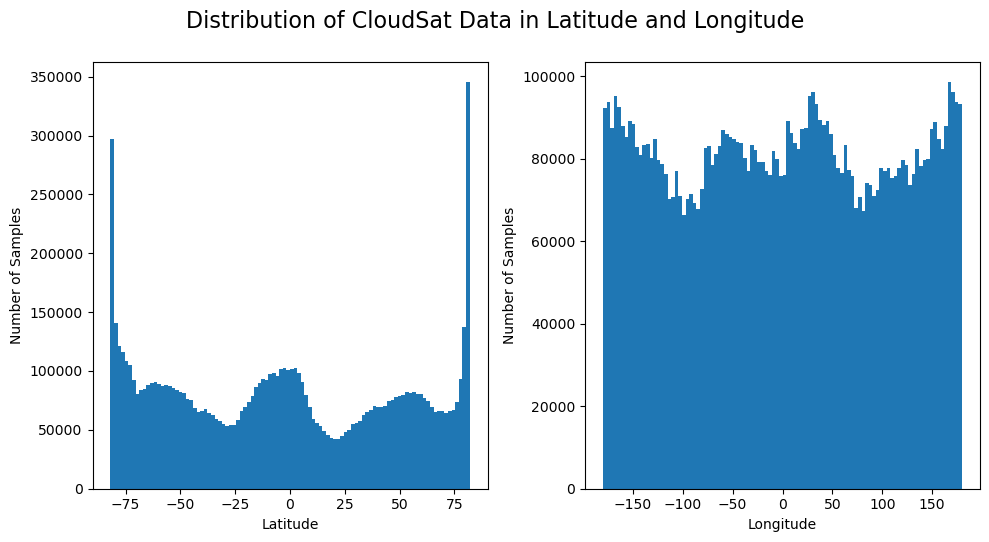

In [13]:
#Find the distribution of latitudes in the dataset

data = pd.read_csv('/data/debasish/cloudsatdata/cldclasslidar/2019jan/2019jan.csv')
print(data['lat'].min(),data['lat'].max())
#data['lat'].hist(bins=100)

#Plot the latitudal and longitudinal distribution of the data in a single plot with two subplots

fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.figtext(0.5,1.051,'Distribution of CloudSat Data in Latitude and Longitude',ha='center', va='center',fontsize=16)
ax[0].hist(data['lat'],bins=100)
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Number of Samples')
ax[1].hist(data['lon'],bins=100)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Number of Samples')
plt.tight_layout()

<AxesSubplot:>

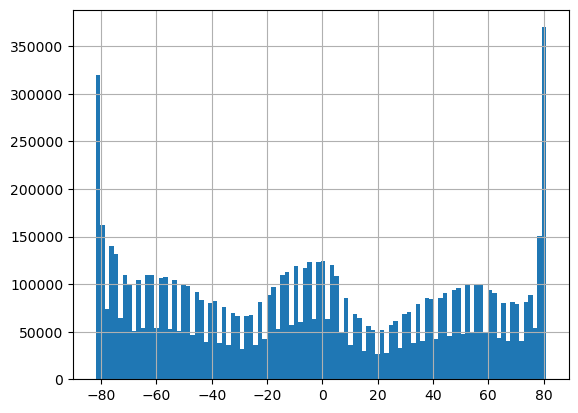

In [10]:
np.floor(data['lat']).hist(bins=100)